In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

In [2]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state
        
        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1

    def sampler_init_state(self):
        return np.zeros(self.Nx)

    def EulerSolution(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.sampler_init_state()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            dwt = np.random.normal(0, 1, size = self.Nx) * np.sqrt(dt)
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt
        return t_data, x_data

Task 1. Use the stochastic integral Ito, $N=1000$ to simulate and plot a path with $X_0 = 10$ of

the Ornstein-Uhlenbeck process, $\mathbb{\theta} = (-5.0, 0.0, 3.5)$;

the Cox-Ingersoll-Ross process, $\mathbb{\theta} = (2.00, 0.20, 0.15)$;

the Black-Scholes-Merton process, $\mathbb{\theta} = (1.0, 0.2)$.
   

In [3]:
class OrnsteinUhlenbeckProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]

    def sampler_init_state(self):
        return self.params[1] * np.ones(self.Nx)


class CoxIngersollRossProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))

    def sampler_init_state(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)


class BlackScholesMertonProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x

    def sampler_init_state(self):
        return np.ones(self.Nx)

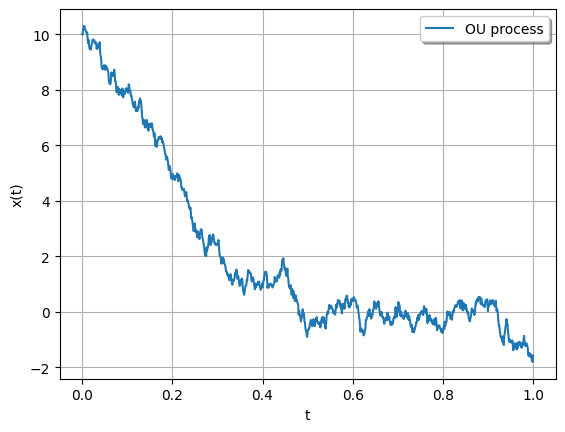

In [4]:
T = 1
Nx = 1
Nt = 1000

init_state = 10 * np.ones(Nx)

theta = 5
mu = 0
sigma = 3.5
params = [theta, mu, sigma]

OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)
t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'OU process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

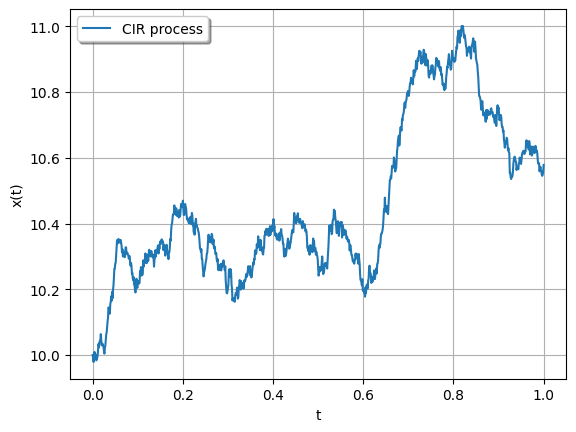

In [5]:
theta1 = 2
theta2 = 0.2
theta3 = 0.15
params = [theta1, theta2, theta3]

CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'CIR process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

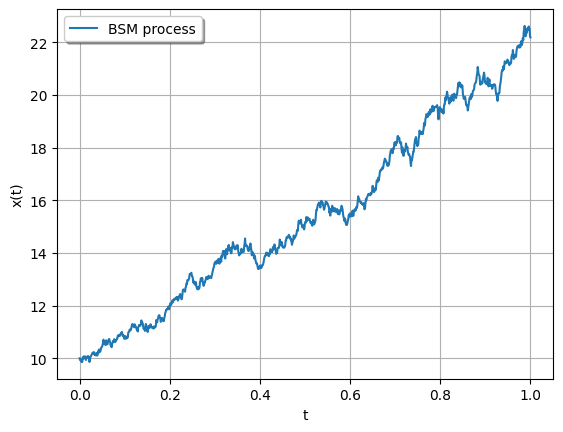

In [6]:
theta1 = 1.0
theta2 = 0.2
params = [theta1, theta2]

BSMProcess = BlackScholesMertonProcess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'BSM process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 2. Compute a confidence interval of the CIR process from the previous task. Plot the paths and a confidence interval.

In [7]:
def zeta(sigma, theta, t, s):
    return sigma**2 / (4 * theta) * (1 - np.exp(-theta * (t - s)))

def CIRbounds(alpha_interval, params, t, s, xs):
    theta1, theta2, theta3 = params[0], params[1], params[2]
    theta = theta2
    beta = theta1 / theta2
    sigma = theta3

    k = 4  / sigma**2 * theta * beta
    lambd = 4 * theta / sigma**2  * np.exp(-theta * (t - s)) / (1 - np.exp(-theta * (t - s))) * xs
    ksi = norm.ppf(1 - alpha_interval / 2)

    b1 = zeta(sigma, theta, t, s) * (k + lambd - ksi * np.sqrt(2 * (k + 2 * lambd)))
    b2 = zeta(sigma, theta, t, s) * (k + lambd + ksi * np.sqrt(2 * (k + 2 * lambd)))
    return [b1, b2]


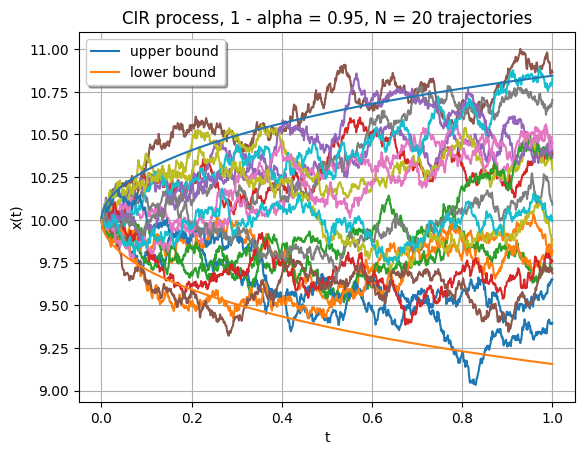

In [8]:
theta1 = 2
theta2 = 0.2
theta3 = 0.15
params = [theta1, theta2, theta3]

Nx = 20

x0 = 10
init_state = x0 * np.ones(Nx)
alpha_interval = 0.05

CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRProcess.EulerSolution()
for k in range(0, Nx):
    plt.plot(t_data, x_data[:,k])

low_bound_data = np.zeros_like(t_data)
up_bound_data = np.zeros_like(t_data)

for i in range(1, len(t_data)):
    bounds = CIRbounds(alpha_interval, params, t_data[i], 0, x0)
    low_bound_data[i] = bounds[0]
    up_bound_data[i] = bounds[1]
low_bound_data[0] = x0
up_bound_data[0] = x0
plt.plot(t_data, up_bound_data, label = f"upper bound")
plt.plot(t_data, low_bound_data, label = f"lower bound")

plt.title(f"CIR process, 1 - alpha = {1-alpha_interval}, N = {Nx} trajectories")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 3. For the Ornstein-Uhlenbeck process
$$
dX_t = \theta(\mu - X_t)dt + \sigma dW_t, \quad \theta = 1, \quad \mu = 1.2, \quad \sigma = 0.3
$$
generate three paths: $X_0 = 0.0, 2.0, \mathcal{N}\left(\mu, \frac{\sigma^2}{2\theta}\right)$ and plot in graph.


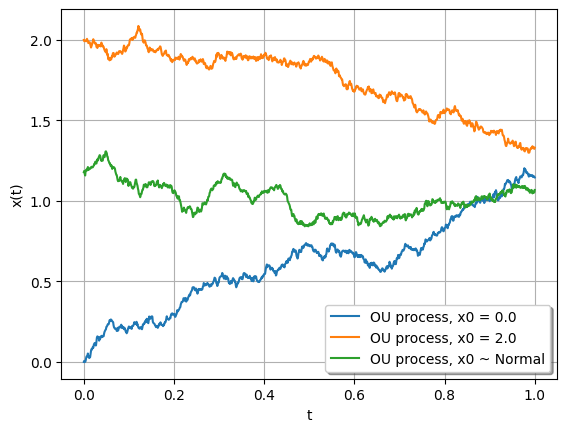

In [9]:
T = 1
Nx = 1
Nt = 1000

theta = 1
mu = 1.2
sigma = 0.3
params = [theta, mu, sigma]

x0 = 0.0
init_state = x0 * np.ones(Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 = {x0}')

x0 = 2.0
init_state = x0 * np.ones(Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 = {x0}')


init_state = np.random.normal(mu, sigma**2/(2 * theta), size = Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 ~ Normal')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Define a path with the stationary distribution from the graph and prove mathematically.

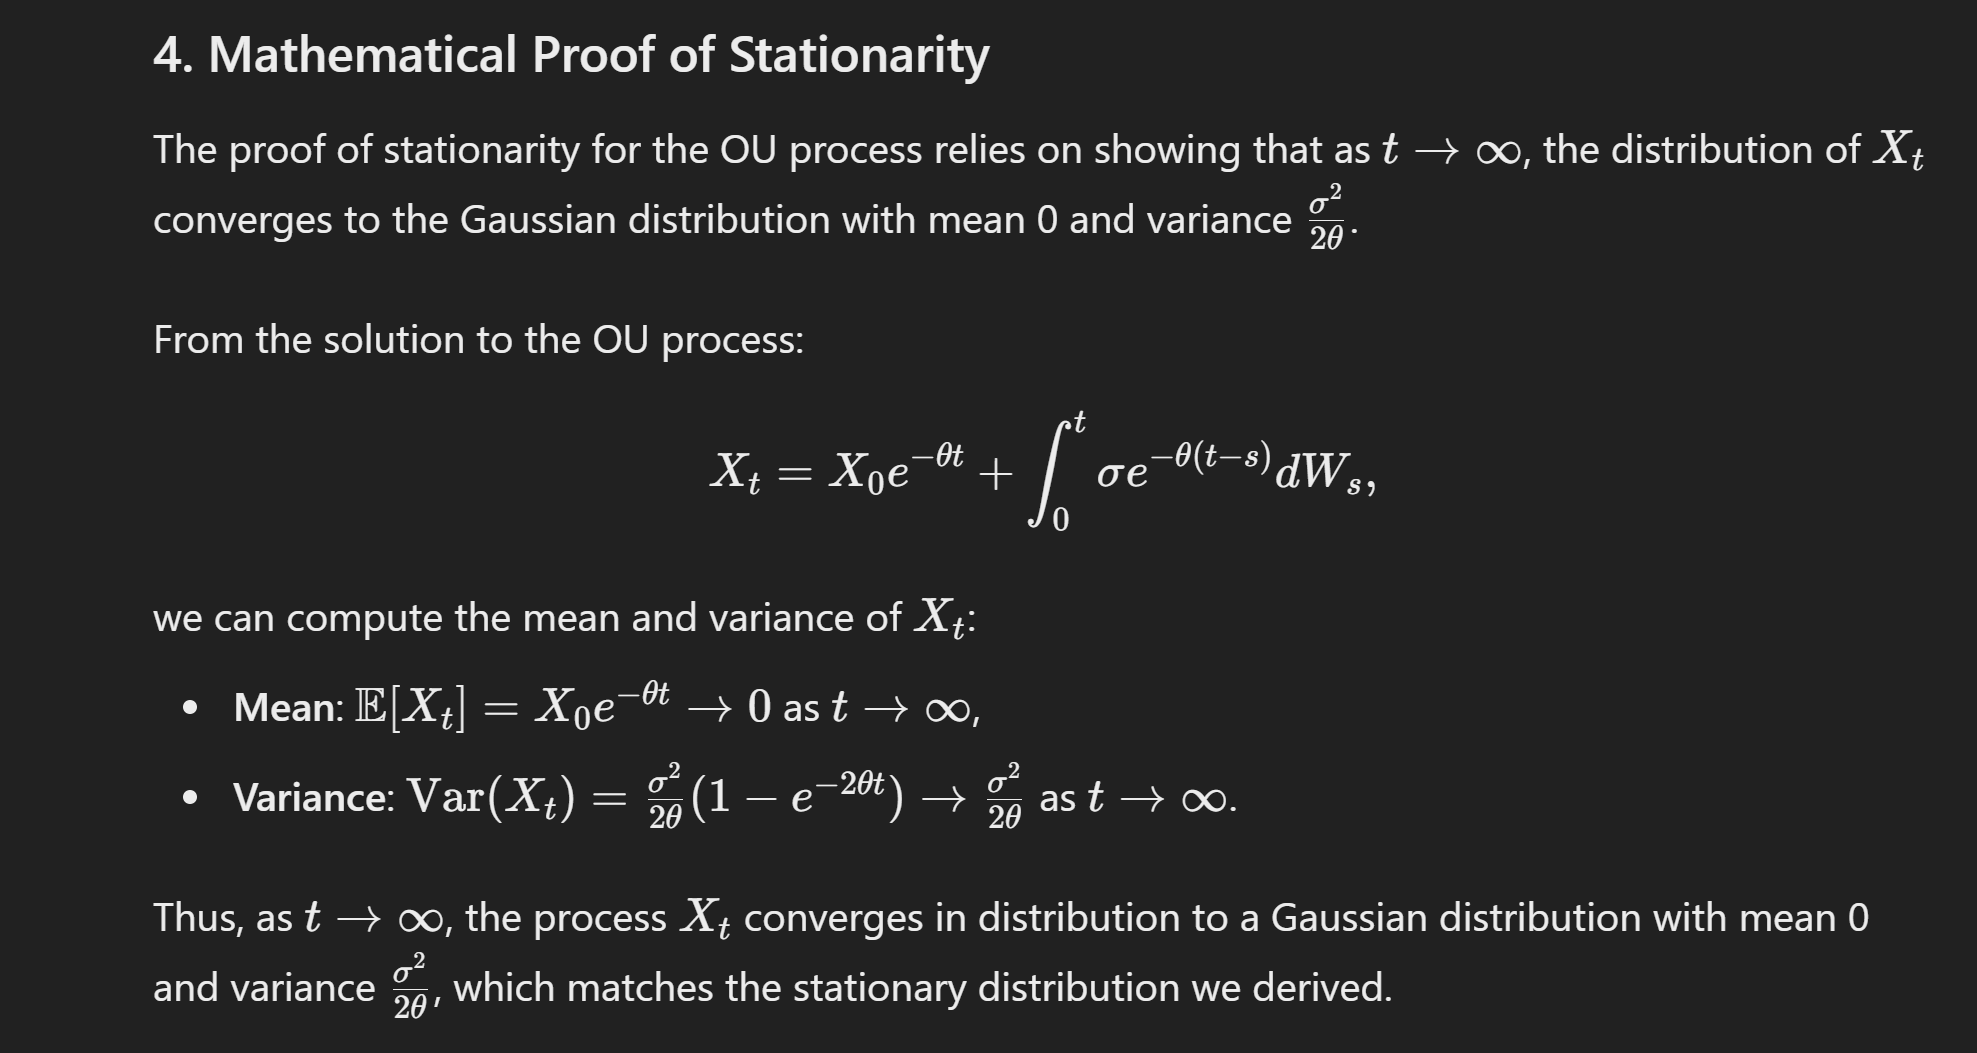

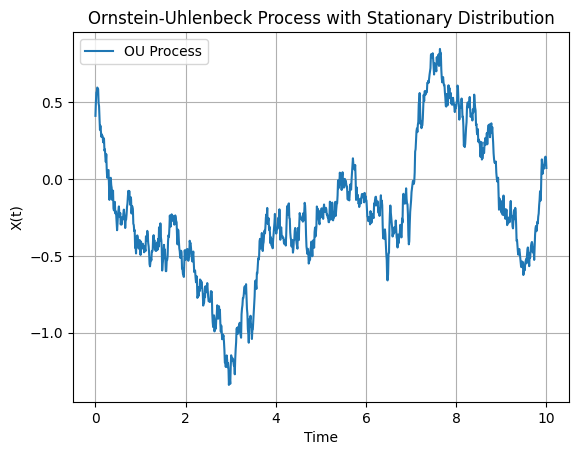

In [10]:
# Parameters 
theta = 1.0   # Speed of mean reversion
sigma = 0.5   # Volatility
T = 10        # Total time
Nt = 1000     # Number of time steps
dt = T / Nt   # Time step size

# Simulate a path
t = np.linspace(0, T, Nt + 1)
X = np.zeros(Nt + 1)
X[0] = np.random.normal(0, np.sqrt(sigma**2 / (2 * theta)))  # Initial state from stationary distribution

# Euler-Maruyama method to simulate the path
for i in range(1, Nt + 1):
    dW = np.random.normal(0, np.sqrt(dt))  # Brownian increment
    X[i] = X[i - 1] - theta * X[i - 1] * dt + sigma * dW

# Plot the simulated path
plt.plot(t, X, label="OU Process")
plt.title("Ornstein-Uhlenbeck Process with Stationary Distribution")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.grid(True)
plt.legend()
plt.show()


Task 4.  Design a process that stays in the interval $[0, 1]$ and mean-reverts
around $1/2$, generate a path and plot it in graph. Prove your solution.


Hint
$$
\mu(x) = \theta (1/2 - x), \quad \sigma(x) = \sigma \cdot x (1-x).
$$

That is
$$
dx = \theta (1/2 - x )dt + \sigma \cdot x (1-x) dW.
$$
Note: diffusion goes to zero at boundaries $\sigma(0) = \sigma(1) = 0$ and
mean-reverts  $⇒$ always stay in $[0, 1]$.

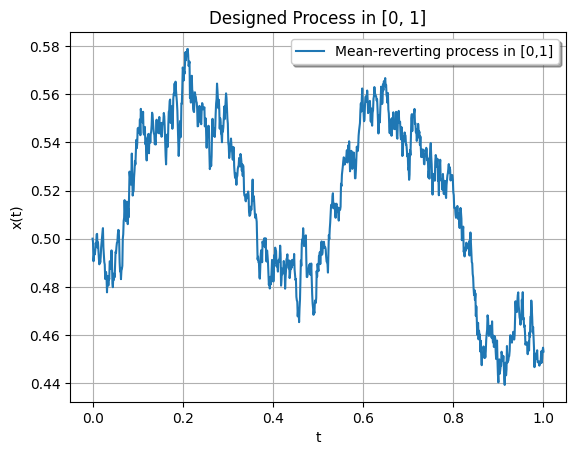

In [11]:
class DesignedProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [theta, sigma]
        self.bxt = lambda x: self.params[0] * (0.5 - x)
        self.sigmaxt = lambda x: self.params[1] * x * (1 - x)
    
    def sampler_init_state(self):
        return 0.5 * np.ones(self.Nx)  # Start at 0.5 (mean-reverting level)

# Parameters
theta = 2  # Mean-reversion strength
sigma = 0.5  # Volatility
params = [theta, sigma]

T = 1
Nx = 1
Nt = 1000
init_state = 0.5 * np.ones(Nx)

# Instantiate and simulate the process
designed_process = DesignedProcess(params, T, Nx, Nt, init_state)
t_data, x_data = designed_process.EulerSolution()

# Plot the process
plt.plot(t_data, x_data, label='Mean-reverting process in [0,1]')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Designed Process in [0, 1]")
plt.grid(True)
plt.show()

Task 5. Using the class template from Task 1, create classes and plot graphs for the following processes:

1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
1.   Nonlinear mean reversion Ait-Sahalia model;
2.   Jacobi diffusion process;
1.   Ahn and Gao (inverse of Feller’s square root) model;
2.   Radial Ornstein-Uhlenbeck process.





In [12]:
class NameProcess(StochasticProcess):
      def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = ...

      def sampler_init_state(self):
        return

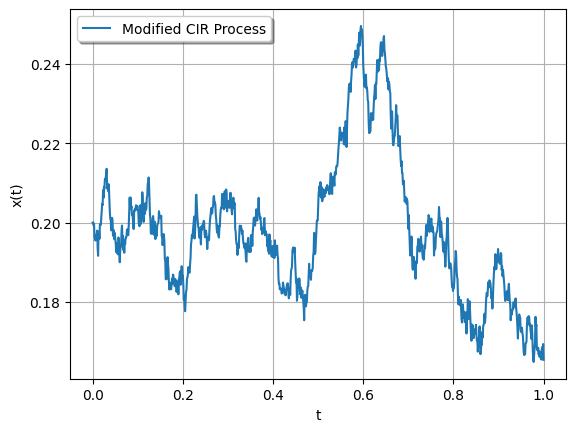

In [13]:
class ModifiedCIRProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [theta1, theta2, theta3, alpha]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2] * x**self.params[3]
    
    def sampler_init_state(self):
        return self.params[1] * np.ones(self.Nx)

# Example usage:
params = [2, 0.2, 0.15, 0.5]  # theta1, theta2, theta3, alpha
process = ModifiedCIRProcess(params, T=1, Nx=1, Nt=1000, init_state=0.2*np.ones(1))
t_data, x_data = process.EulerSolution()

plt.plot(t_data, x_data, label='Modified CIR Process')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()


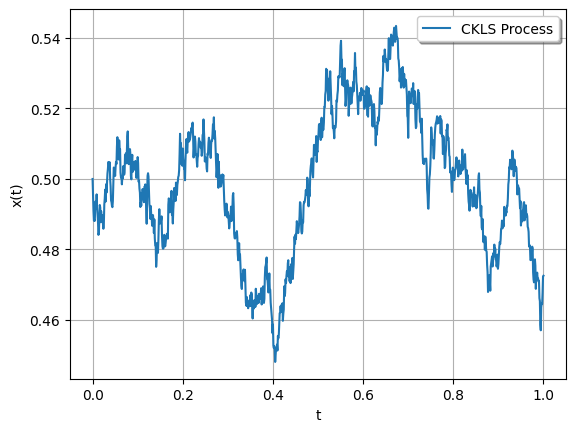

In [14]:
class CKLSProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [theta1, theta2, theta3, alpha]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2] * x**self.params[3]
    
    def sampler_init_state(self):
        return self.params[1] * np.ones(self.Nx)

# Example usage:
params = [2, 0.5, 0.15, 0.7]  # theta1, theta2, theta3, alpha
process = CKLSProcess(params, T=1, Nx=1, Nt=1000, init_state=0.5*np.ones(1))
t_data, x_data = process.EulerSolution()

plt.plot(t_data, x_data, label='CKLS Process')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()


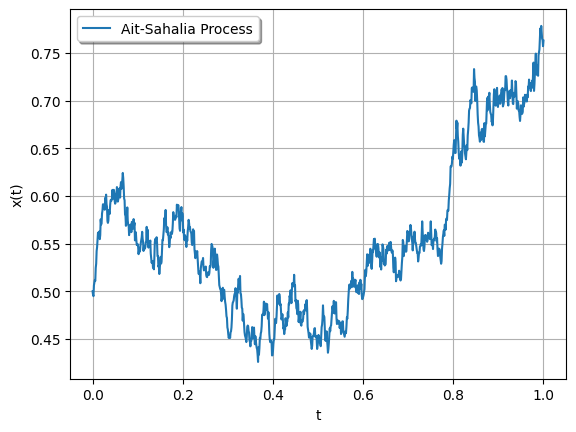

In [15]:
class AitSahaliaProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [a1, a2, a3, p, q, sigma, alpha]
        self.bxt = lambda x: self.params[0] * x + self.params[1] * x**self.params[3] + self.params[2] * x**self.params[4]
        self.sigmaxt = lambda x: self.params[5] * x**self.params[6]
    
    def sampler_init_state(self):
        return 0.5 * np.ones(self.Nx)

# Example usage:
params = [0.5, -0.2, 0.1, 2, 3, 0.3, 0.5]  # a1, a2, a3, p, q, sigma, alpha
process = AitSahaliaProcess(params, T=1, Nx=1, Nt=1000, init_state=0.5*np.ones(1))
t_data, x_data = process.EulerSolution()

plt.plot(t_data, x_data, label='Ait-Sahalia Process')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()


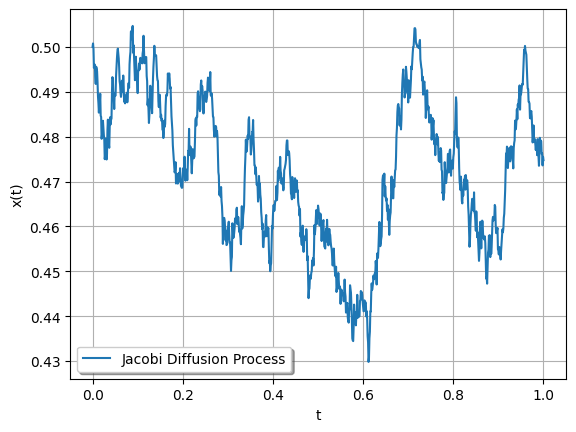

In [16]:
class JacobiProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [theta1, theta2, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2] * x * (1 - x)
    
    def sampler_init_state(self):
        return 0.5 * np.ones(self.Nx)

# Example usage:
params = [2, 0.5, 0.3]  # theta1, theta2, sigma
process = JacobiProcess(params, T=1, Nx=1, Nt=1000, init_state=0.5*np.ones(1))
t_data, x_data = process.EulerSolution()

plt.plot(t_data, x_data, label='Jacobi Diffusion Process')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()


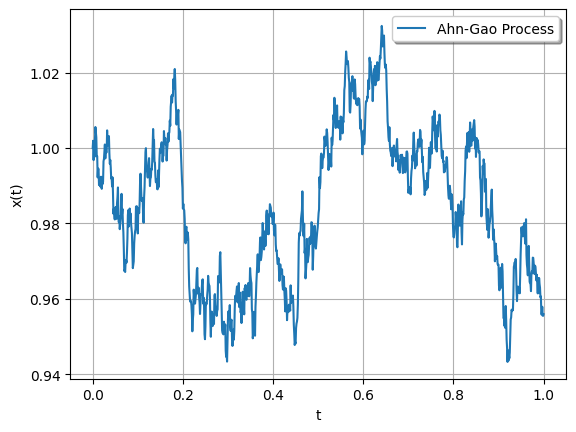

In [17]:
class AhnGaoProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [theta1, theta2, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - 1 / x)
        self.sigmaxt = lambda x: self.params[2]
    
    def sampler_init_state(self):
        return self.params[1] * np.ones(self.Nx)

# Example usage:
params = [2, 1, 0.1]  # theta1, theta2, sigma
process = AhnGaoProcess(params, T=1, Nx=1, Nt=1000, init_state=np.ones(1))
t_data, x_data = process.EulerSolution()

plt.plot(t_data, x_data, label='Ahn-Gao Process')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()


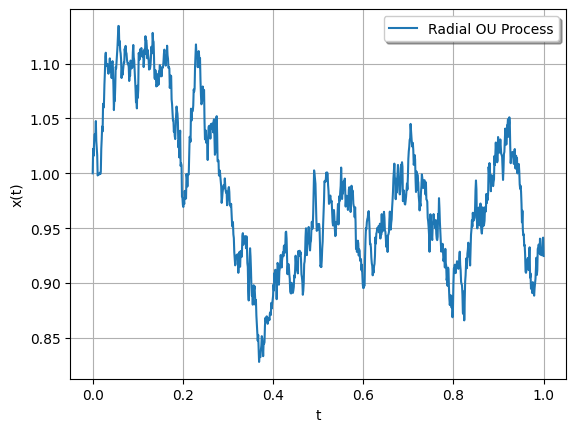

In [18]:
class RadialOUProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(x)
    
    def sampler_init_state(self):
        return self.params[1] * np.ones(self.Nx)

# Example usage:
params = [2, 1, 0.3]  # theta, mu, sigma
process = RadialOUProcess(params, T=1, Nx=1, Nt=1000, init_state=1*np.ones(1))
t_data, x_data = process.EulerSolution()

plt.plot(t_data, x_data, label='Radial OU Process')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()


Task 6.

Let $$X(t)=e^{-\kappa t} X_0 + \theta (1-e^{-\kappa t}) + \sigma e^{-\kappa t} \int_0^t e^{\kappa s}\sqrt{X(t)}dW(s)$$ be extract solution for CIR model.


 Expand the functionality of the class CoxIngersollRossProcess(StochasticProcess) and compute the first and second moments of the extract solution $\mathbb{E}\{X^n(t)\}$ using the general formula [Jafari, 2017]
$$
\mathbb{E}\{X^n(t)\} = \sum_{j=0}^{[n/2]}A^{n-2j}(t)B^{2j}(t)
\left(\frac{1}{2\kappa}(e^{2\kappa t} - 1)\right)^{2j}, \quad \forall n \in \mathbb{N},
$$
where $A(t)=e^{-\kappa t X_0} + \theta(1-e^{-\kappa t})$,
$B(t)=\sigma e^{-\kappa t}$, $[n/2]$ denotes the greatest integer less than or equal to $\frac{n}{2}$ and $\kappa=1$, $\theta =0.45$, $\sigma=1$.

Jafari M.A. [The Moments for Solution of the Cox-Ingersoll-Ross Interest Rate Model](https://www.sciepub.com/portal/downloads?doi=10.12691/jfe-5-1-4&filename=jfe-5-1-4.pdf) / M.A. Jafari, S. Abbasian // Journal of Finance
and Economics. – 2017. – Vol. 5, № 1. – P. 34—37

In [19]:
class CoxIngersollRossProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.kappa, self.theta, self.sigma = self.params
    
    def A(self, t):
        """Compute A(t) = e^(-kappa t) X_0 + theta (1 - e^(-kappa t))"""
        return np.exp(-self.kappa * t) * self.init_state + self.theta * (1 - np.exp(-self.kappa * t))

    def B(self, t):
        """Compute B(t) = sigma e^(-kappa t)"""
        return self.sigma * np.exp(-self.kappa * t)

    def moment(self, t, n):
        """Compute the n-th moment E[X^n(t)] using the Jafari formula."""
        A_t = self.A(t)
        B_t = self.B(t)
        moment_sum = 0
        for j in range((n // 2) + 1):
            moment_sum += (A_t ** (n - 2 * j)) * (B_t ** (2 * j)) * ((1 / (2 * self.kappa) * (np.exp(2 * self.kappa * t) - 1)) ** (2 * j))
        return moment_sum

    def first_moment(self, t):
        """Compute the first moment E[X(t)]"""
        return self.moment(t, 1)

    def second_moment(self, t):
        """Compute the second moment E[X^2(t)]"""
        return self.moment(t, 2)


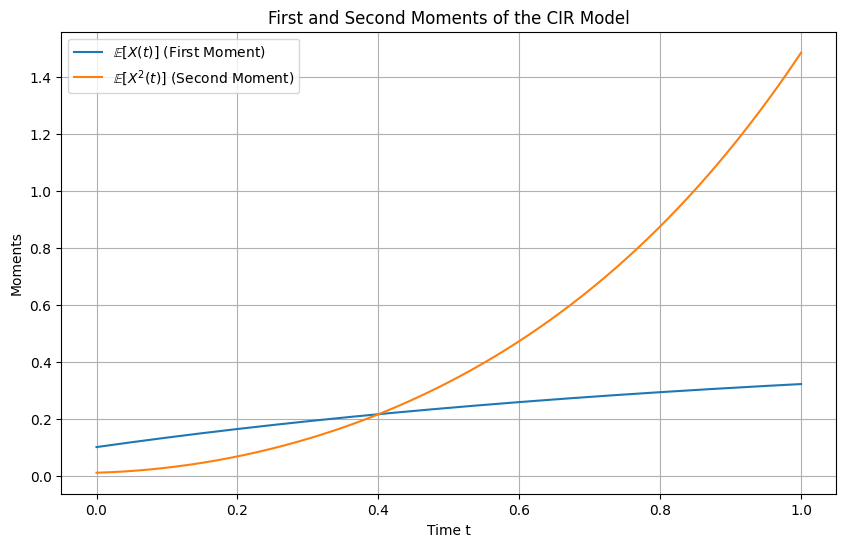

In [20]:
# Set parameters
kappa = 1
theta = 0.45
sigma = 1
init_state = 0.1  # Initial value of the process

# Instantiate the CIR process
params = [kappa, theta, sigma]
T = 1  # Time horizon
Nx = 1  # Number of paths
Nt = 1000  # Number of time steps
cir_process = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)

# Time points
time_points = np.linspace(0, T, Nt)

# Compute first and second moments at each time point
first_moments = [cir_process.first_moment(t) for t in time_points]
second_moments = [cir_process.second_moment(t) for t in time_points]

# Plotting the moments
plt.figure(figsize=(10, 6))
plt.plot(time_points, first_moments, label=r'$\mathbb{E}[X(t)]$ (First Moment)')
plt.plot(time_points, second_moments, label=r'$\mathbb{E}[X^2(t)]$ (Second Moment)')
plt.title("First and Second Moments of the CIR Model")
plt.xlabel("Time t")
plt.ylabel("Moments")
plt.legend(loc='best')
plt.grid(True)
plt.show()


Task 7. Suppose we have a standard (zero-mean) Ornstein-Uhlenbeck process defined by
$$
dX_t = -\theta X_t dt + \sigma dW_t, \quad X_0 = x_0,
$$
where $\sigma$ is interpreted as the volatility, and $\theta$ is the speed of reversion.

Define a half-life at time $s$ as the time $h$ such that $𝔼(x_h|x_s)=\frac{1}{2}x_s$. That is, how long until half the deviation from the mean is, in expectation, lost.

This is easy to compute because
\begin{align}
  \frac{1}{2}x_s & =  𝔼(x_h|x_s) \\
                 & = x_s\exp(-\theta h)
\end{align}
and we can cancel the $x_s$ terms to give
\begin{align}
  \frac{1}{2} = \exp(-\theta h)
\end{align}
which rearranges to
\begin{align}
  h = \frac{\ln(2)}{\theta}
\end{align}
The cancellation of $x_s$ means that a half-life does not depend on either $s$ or $x_s$ and so we are entitled to call it "the" half-life of the process.

As one can see, the half-life is a constant for an Ornstein-Uhlenbeck process.

